In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import Isomap
import time
from tqdm import tqdm

import librosa
from librosa import cqt
from librosa.core import amplitude_to_db
from librosa.display import specshow

import os
import glob

In [2]:
data_dir= '/Users/sripathisridhar/googleDrive/projects/helix/helix2019_data/SOL'

In [3]:
file_paths= sorted(glob.glob(os.path.join(data_dir, '**', '*.wav')))

file_names= []
for file_path in file_paths:
    file_names.append(os.path.basename(file_path))

In [4]:
hop_size= 512
q= 24

In [5]:
features_dict= {}
feature_key= ''

for file_path in tqdm(file_paths, disable=False):

    # Read audio files
    waveform, sample_rate= librosa.load(file_path, sr=None)

    # Compute CQTs
    cqt_complex= cqt(y= waveform,
                    sr= sample_rate,
                    hop_length= hop_size,
                    bins_per_octave= q,
                    n_bins= q*7,
                    sparsity=1e-6,
                    )
    scalogram= np.abs(cqt_complex)**2

    # Find frame with maximum RMS value
    rms= librosa.feature.rms(y= waveform,
                              hop_length= hop_size,
                             )
    rms_argmax= np.argmax(rms)
    feature= scalogram[:,rms_argmax]

    # Stack in dict
    file_name= os.path.basename(file_path)
    feature_key= f'{file_name}'
    features_dict[feature_key]= feature

100%|██████████| 1212/1212 [05:17<00:00,  4.49it/s]


In [27]:
grid = {
    'Q': [24],
    'k': [3],
    'comp': ['none','cuberoot'],
    'instr': ['all'],
    'dyn': ['all']
}

settings = list(ParameterGrid(grid))

for setting in settings:
    
    if setting["instr"] == 'all':
        setting['instr'] = ''
    
    if setting['dyn'] == 'all':
        setting['dyn'] = ''

## Fig 5a: Linear loudness mapping

In [29]:
batch_str= []
q= 0
CQT_OCTAVES= 7

features_keys= list(features_dict.keys())

setting= settings[0]
    
q= setting['Q']
# Batch process and store in a folder
batch_str= [setting['instr'], setting['dyn']]
#     print(batch_str)

batch_features= []
for feature_key in features_keys:
    # Get features that match setting

    if all(x in feature_key for x in batch_str):
        batch_features.append(features_dict[feature_key])

batch_features= np.stack(batch_features, axis=1)
# print(batch_features.shape)

# Isomap parameters
hop_size= 512
compression= setting['comp']
if compression== 'none':
    features= batch_features
elif compression== 'cuberoot':
    features= np.power(batch_features, 1/3.0)
n_neighbors= setting['k']
n_dimensions= 3
n_octaves= 3    

# Prune feature matrix
bin_low = np.where((np.std(features, axis=1) / np.std(features)) > 0.1)[0][0] + q
bin_high = bin_low + n_octaves*q 
X = features[bin_low:bin_high, :]

# Z-score Standardization- improves contrast in correlation matrix
mus = np.mean(X, axis=1)
sigmas = np.std(X, axis=1)
X_std = (X - mus[:, np.newaxis]) / (1e-6 + sigmas[:, np.newaxis]) # 1e-6 to avoid runtime division by zero

# Pearson correlation matrix
rho_std = np.dot(X_std, X_std.T) / X_std.shape[1]

# Isomap embedding
isomap= Isomap(n_components= n_dimensions, n_neighbors= n_neighbors)
coords = isomap.fit_transform(rho_std)

# Get note value
freqs= librosa.cqt_frequencies(q*CQT_OCTAVES, fmin=librosa.note_to_hz('C1'), bins_per_octave=q) #librosa CQT default fmin is C1
chroma_list= librosa.core.hz_to_note(freqs[bin_low:bin_high])

notes=[]
reps= q//12
for chroma in chroma_list:
    for i in range(reps):
        notes.append(chroma)
 

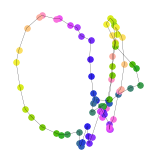

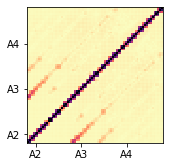

In [30]:
curr_fig= plt.figure(figsize=(5.5, 2.75))
ax= curr_fig.add_subplot(121)
ax.axis('off')

import colorcet as cc
subsampled_color_ids = np.floor(np.linspace(0, 256, q, endpoint=False)).astype('int')
color_list= [cc.cyclic_mygbm_30_95_c78[i] for i in subsampled_color_ids]

# Plot embedding with color
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], color= color_list[i%q], s=30.0)

plt.plot(coords[:, 0], coords[:, 1], color='black', linewidth=0.2)

# Plot Pearson correlation matrix
rho_frequencies = freqs[bin_low:bin_high]

freq_ticklabels = ['A2', 'A3', 'A4']
freq_ticks = librosa.core.note_to_hz(freq_ticklabels)

tick_bins = []
tick_labels= []
for i,freq_tick in enumerate(freq_ticks):
    tick_bin = np.argmin(np.abs(rho_frequencies-freq_tick))
    tick_bins.append(tick_bin)
    tick_labels.append(freq_ticklabels[i])

plt.figure(figsize=(2.5,2.5))
plt.imshow(np.abs(rho_std), cmap='magma_r')
plt.xticks(tick_bins)
plt.gca().set_xticklabels(freq_ticklabels)
# plt.xlabel('Log-frequency (octaves)')
plt.yticks(tick_bins)
plt.gca().set_yticklabels(freq_ticklabels)
# plt.ylabel('Log-frequency (octaves)')
plt.gca().invert_yaxis()

plt.clim(0, 1)


## Fig 5b: Cube-root loudness mapping

In [31]:
batch_str= []
q= 0
CQT_OCTAVES= 7

features_keys= list(features_dict.keys())

setting= settings[1]
    
q= setting['Q']
# Batch process and store in a folder
batch_str= [setting['instr'], setting['dyn']]
#     print(batch_str)

batch_features= []
for feature_key in features_keys:
    # Get features that match setting

    if all(x in feature_key for x in batch_str):
        batch_features.append(features_dict[feature_key])

batch_features= np.stack(batch_features, axis=1)
# print(batch_features.shape)

# Isomap parameters
hop_size= 512
compression= setting['comp']
if compression== 'none':
    features= batch_features
elif compression== 'cuberoot':
    features= np.power(batch_features, 1/3.0)
n_neighbors= setting['k']
n_dimensions= 3
n_octaves= 3    

# Prune feature matrix
bin_low = np.where((np.std(features, axis=1) / np.std(features)) > 0.1)[0][0] + q
bin_high = bin_low + n_octaves*q 
X = features[bin_low:bin_high, :]

# Z-score Standardization- improves contrast in correlation matrix
mus = np.mean(X, axis=1)
sigmas = np.std(X, axis=1)
X_std = (X - mus[:, np.newaxis]) / (1e-6 + sigmas[:, np.newaxis]) # 1e-6 to avoid runtime division by zero

# Pearson correlation matrix
rho_std = np.dot(X_std, X_std.T) / X_std.shape[1]

# Isomap embedding
isomap= Isomap(n_components= n_dimensions, n_neighbors= n_neighbors)
coords = isomap.fit_transform(rho_std)

# Get note value
freqs= librosa.cqt_frequencies(q*CQT_OCTAVES, fmin=librosa.note_to_hz('C1'), bins_per_octave=q) #librosa CQT default fmin is C1
chroma_list= librosa.core.hz_to_note(freqs[bin_low:bin_high])

notes=[]
reps= q//12
for chroma in chroma_list:
    for i in range(reps):
        notes.append(chroma)
 

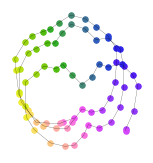

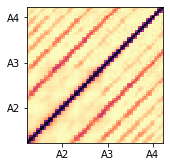

In [32]:
curr_fig= plt.figure(figsize=(5.5, 2.75))
ax= curr_fig.add_subplot(121)
ax.axis('off')

import colorcet as cc
subsampled_color_ids = np.floor(np.linspace(0, 256, q, endpoint=False)).astype('int')
color_list= [cc.cyclic_mygbm_30_95_c78[i] for i in subsampled_color_ids]

# Plot embedding with color
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], color= color_list[i%q], s=30.0)

plt.plot(coords[:, 0], coords[:, 1], color='black', linewidth=0.2)

# Plot Pearson correlation matrix
rho_frequencies = freqs[bin_low:bin_high]

freq_ticklabels = ['A2', 'A3', 'A4']
freq_ticks = librosa.core.note_to_hz(freq_ticklabels)

tick_bins = []
tick_labels= []
for i,freq_tick in enumerate(freq_ticks):
    tick_bin = np.argmin(np.abs(rho_frequencies-freq_tick))
    tick_bins.append(tick_bin)
    tick_labels.append(freq_ticklabels[i])

plt.figure(figsize=(2.5,2.5))
plt.imshow(np.abs(rho_std), cmap='magma_r')
plt.xticks(tick_bins)
plt.gca().set_xticklabels(freq_ticklabels)
# plt.xlabel('Log-frequency (octaves)')
plt.yticks(tick_bins)
plt.gca().set_yticklabels(freq_ticklabels)
# plt.ylabel('Log-frequency (octaves)')
plt.gca().invert_yaxis()

plt.clim(0, 1)
